In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
import pickle
import re
import math

D:\ProgramFiles\AnacondaDistribution\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [81]:

house_df = pd.read_csv(r'Craiglist_HouseData3.csv')
house_df.head()



,Unnamed: 0,Price,Bedroom,Area,Title,Place,Post Timing,Finishing,House Type,Parking Type,Bathroom,Link
0,1,nan,NaN,nan,Semiahmoo Town Centre 7500 sq ft lot,NaN,2020-07-20T19:05:26-0700,unfurnished,apartment,NaN,1,https://vancouver.craigslist.org/rds/reo/d/bla...
1,2,1324888.000,7,7771.000,** OPEN HOUSE JULY 26 FOR THE BEST PRICED HOME...,Newton,2020-07-25T15:47:15-0700,unfurnished,house,NaN,1,https://vancouver.craigslist.org/rds/reb/d/sur...
2,3,728000.000,1,547.000,***INVESTOR ALERT - AIRBNB ALLOWED*** Downtow...,Whistler,2020-07-03T22:11:07-0700,unfurnished,apartment,NaN,1,https://vancouver.craigslist.org/van/reb/d/daw...
3,4,1098800.000,6,547.000,6 bed house with a basement suite in Sullivan ...,Surrey,2020-07-25T14:37:59-0700,unfurnished,apartment,NaN,4.5,https://vancouver.craigslist.org/rds/reb/d/sur...
4,5,632000.000,2,1305.000,High Level Executive 2 Bedroom Condo in Coquitlam,North Coquitlam,2020-07-25T14:42:39-0700,unfurnished,condo,attached garage,2,https://vancouver.craigslist.org/pml/reb/d/coq...


In [82]:
#drop Price with Null
house_df.dropna(subset = ["Price"], inplace=True)
house_df = house_df[house_df["Price"]>1]
house_df = house_df[house_df["House Type"] !="land"]
# col_remove = ["Title", "Place", "Post Timing", "Link"]
# house_df.drop(col_remove, axis= 1, inplace =True)
house_df = house_df.loc[:, ~house_df.columns.str.match('Unnamed')]
house_df.drop(house_df[house_df['Title'].str.contains("rent")].index, inplace=True)
house_df.drop(house_df[house_df['Title'].str.contains("Rent")].index, inplace=True)
house_df.drop_duplicates(subset = ["Title", "Area", "Place", "Finishing", "Bedroom","House Type"], inplace=True) 

In [83]:
# remove land data
house_df.drop(house_df[house_df['House Type']=='land'].index, inplace=True)
land_index = house_df[((house_df['Title'].str.contains("Land") | 
           house_df['Title'].str.contains("land")) & (house_df["Bedroom"].isnull()))].index
house_df.drop(land_index, axis=0, inplace=True)

In [84]:
# remove acre data
land_index = house_df[((house_df['Title'].str.contains("acre") | 
           house_df['Title'].str.contains("Acre")) & (house_df["Bedroom"].isnull()))].index
house_df.drop(land_index, axis=0, inplace=True)

In [85]:
# replace nan in House Type with others
house_df["House Type"].fillna("others", inplace=True)

In [86]:
# normalise the price
house_df["Price"] = np.log(house_df["Price"])

In [87]:
#bathroom null and replace values 


In [88]:
house_df

,Price,Bedroom,Area,Title,Place,Post Timing,Finishing,House Type,Parking Type,Bathroom,Link
1,14.097,7,7771.000,** OPEN HOUSE JULY 26 FOR THE BEST PRICED HOME...,Newton,2020-07-25T15:47:15-0700,unfurnished,house,NaN,1,https://vancouver.craigslist.org/rds/reb/d/sur...
2,13.498,1,547.000,***INVESTOR ALERT - AIRBNB ALLOWED*** Downtow...,Whistler,2020-07-03T22:11:07-0700,unfurnished,apartment,NaN,1,https://vancouver.craigslist.org/van/reb/d/daw...
3,13.910,6,547.000,6 bed house with a basement suite in Sullivan ...,Surrey,2020-07-25T14:37:59-0700,unfurnished,apartment,NaN,4.5,https://vancouver.craigslist.org/rds/reb/d/sur...
4,13.357,2,1305.000,High Level Executive 2 Bedroom Condo in Coquitlam,North Coquitlam,2020-07-25T14:42:39-0700,unfurnished,condo,attached garage,2,https://vancouver.craigslist.org/pml/reb/d/coq...
5,13.382,1,771.000,Brand New 1 Bed & Den in Award Winning Compass...,402 680 Seylynn Crescent,2020-07-25T14:42:17-0700,unfurnished,condo,attached garage,1,https://vancouver.craigslist.org/van/reb/d/nor...
...,...,...,...,...,...,...,...,...,...,...,...
2783,13.498,2,1174.000,Fantastic 2 Bed / 3 Bath Townhouse in Coquitlam!,6 638 REGAN AVENUE,2020-05-13T04:03:57-0700,unfurnished,townhouse,NaN,3,https://vancouver.craigslist.org/pml/reb/d/coq...
2784,13.773,2,90.000,Cool 2 Bed / 2 Bath Condo in Vancouver!,1007 480 ROBSON STREET,2020-05-13T03:47:06-0700,unfurnished,condo,NaN,2,https://vancouver.craigslist.org/van/reb/d/van...
2785,13.592,3,1163.000,Spacious 3 Bed / 3 Bath Townhouse in Burnaby!,115 7499 6TH STREET,2020-05-27T00:10:34-0700,unfurnished,townhouse,NaN,3,https://vancouver.craigslist.org/bnc/reb/d/bur...
2786,13.090,1,60.000,Amazing 1 Bed / 1 Bath Condo in Coquitlam!,311 700 CLARKE ROAD,2020-05-26T23:12:59-0700,unfurnished,condo,NaN,1,https://vancouver.craigslist.org/pml/reb/d/coq...


In [89]:
house_df.describe()

,Price,Area
count,2084.000,1641.000
mean,13.301,2088.730
std,1.409,16700.137
min,0.693,0.000
25%,13.098,460.000
50%,13.457,879.000
75%,13.911,1484.000
max,19.844,549000.000


In [90]:
print('Bedroom unique values -', house_df['Bedroom'].unique(),'\n')
print('Bathroom unique values -', house_df['Bathroom'].unique(),'\n')
print('House Type -', house_df['House Type'].unique(),'\n')

Bedroom unique values - ['7' '1' '6' '2' '5' '8' '3' '4' nan '9' '0'] 

Bathroom unique values - ['1' '4.5' '2' '0' '5' '9+' '6' '8' '3' '4' '3.5' '2.5' '6.5' '7' '1.5'
 'shared' '5.5' '7.5' nan 'split'] 

House Type - ['house' 'apartment' 'condo' 'townhouse' 'others' 'duplex' 'flat'] 



### Bathroom

In [91]:
#bathroom fillna with groupby(House Type)
house_df['Bathroom'].loc[((house_df['Bathroom']== "9+") 
                         |(house_df['Bathroom']== "shared")
                        |(house_df['Bathroom']== "split")
                         |(house_df['Bathroom']=="0"))] = np.nan
house_df['Bathroom'] = pd.to_numeric(house_df['Bathroom'], downcast='integer')
house_df['Bathroom'].loc[house_df['Bathroom']> 4] = np.nan

D:\ProgramFiles\AnacondaDistribution\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [92]:
house_df.groupby(['House Type'])['Bathroom'].agg(pd.Series.mode)

House Type
apartment   2.000
condo       1.000
duplex      3.500
flat        1.000
house       2.000
others      1.000
townhouse   3.000
Name: Bathroom, dtype: float64

In [93]:
house_df['Bathroom'].loc[((house_df['House Type'] == "apartment") |
              (house_df['House Type'] == "condo")|
              (house_df['House Type'] == "duplex")|
              (house_df['House Type'] == "house"))& (house_df['Bathroom'].isnull())] = 2
house_df['Bathroom'].loc[((house_df['House Type'] == "townhouse"))& (house_df['Bathroom'].isnull())] = 3
house_df['Bathroom'].loc[((house_df['House Type'] == "others"))& (house_df['Bathroom'].isnull())] = 1

In [94]:
house_df['Bathroom'].unique()

array([1. , 2. , 3. , 4. , 3.5, 2.5, 1.5])

In [95]:
house_df.groupby("Bathroom").agg([ 'count']).iloc[:,0]

Bathroom
1.000    560
1.500     50
2.000    890
2.500     92
3.000    303
3.500     49
4.000    140
Name: (Price, count), dtype: int64

In [96]:
house_df["Bathroom"].loc[house_df["Bathroom"]>3] = 4

In [97]:
house_df.groupby("Bathroom").agg([ 'count']).iloc[:,0]

Bathroom
1.000    560
1.500     50
2.000    890
2.500     92
3.000    303
4.000    189
Name: (Price, count), dtype: int64

#### Parking

In [98]:
house_df[house_df['Parking Type'].notnull()].groupby(['House Type','Parking Type']).agg('count').iloc[:,0]

House Type  Parking Type   
apartment   attached garage    229
            detached garage     16
            no parking           6
            street parking      44
condo       attached garage    117
                              ... 
others      no parking           1
            street parking      22
townhouse   attached garage    109
            detached garage     10
            street parking       6
Name: Price, Length: 21, dtype: int64

In [99]:
house_df['Parking Type'].fillna('attached garage', inplace=True)

In [100]:
house_df['Parking Type'].isnull().sum()

0

### Finishing

In [101]:
house_df.rename({'Finishing': 'isFurnished'}, axis=1, inplace=True)  

In [102]:
house_df["isFurnished"].unique()

array(['unfurnished', 'furnished'], dtype=object)

In [103]:
house_df["isFurnished"].replace({'unfurnished':0, 'furnished':1})

1       0
2       0
3       0
4       0
5       0
       ..
2783    0
2784    0
2785    0
2786    0
2787    0
Name: isFurnished, Length: 2084, dtype: int64

### Area

In [104]:
house_df['Area'].fillna(house_df.groupby(['House Type', 'Bathroom'])['Area'].transform('mean'), inplace=True)

In [105]:
house_df.drop(house_df[house_df.Area.isnull()].index,inplace=True)

In [106]:
house_df["Area"].isnull().sum()

0

### Bedroom

In [107]:
house_df.groupby(['House Type'])['Bedroom'].agg(pd.Series.mode)

House Type
apartment    2
condo        2
duplex       4
house        4
others       2
townhouse    3
Name: Bedroom, dtype: object

In [108]:
house_df['Bedroom'].loc[((house_df['House Type'] == "apartment") |
              (house_df['House Type'] == "condo")|
              (house_df['House Type'] == "others"))& (house_df['Bedroom'].isnull())] = 2
house_df['Bedroom'].loc[((house_df['House Type'] == "duplex")|
                        (house_df['House Type'] == "townhouse"))& (house_df['Bedroom'].isnull())] = 3
house_df['Bedroom'].loc[((house_df['House Type'] == "house"))& (house_df['Bedroom'].isnull())] = 4

In [109]:
house_df['Bedroom'] = pd.to_numeric(house_df["Bedroom"])
house_df['Bedroom'].loc[house_df[house_df['Bedroom']>5].index] = 6

In [110]:
house_df['Bedroom'].isnull().sum()

0

#### outliers

In [111]:
def reject_outliers(sr, iq_range=0.5):
    pcnt = (1 - iq_range) / 2
    qlow, median, qhigh = sr.dropna().quantile([pcnt, 0.50, 1-pcnt])
    iqr = qhigh - qlow
    return sr[ (sr - median).abs() <= iqr]

In [112]:
house_df = house_df.loc[reject_outliers(house_df["Price"]).index]

In [113]:
house_df = house_df.loc[reject_outliers(house_df["Area"]).index]

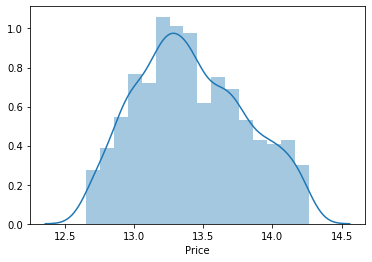

In [114]:
ax = sns.distplot(house_df['Price'])

In [115]:
col_remove = ["Title", "Place", "Post Timing", "Link"]
house_df.drop(col_remove, axis= 1, inplace =True)

In [116]:
house_df.head()

,Price,Bedroom,Area,isFurnished,House Type,Parking Type,Bathroom
2,13.498,1,547.000,unfurnished,apartment,attached garage,1.000
3,13.910,6,547.000,unfurnished,apartment,attached garage,2.000
4,13.357,2,1305.000,unfurnished,condo,attached garage,2.000
5,13.382,1,771.000,unfurnished,condo,attached garage,1.000
6,13.910,2,11.000,unfurnished,condo,attached garage,2.000


In [117]:
house_df.shape

(1410, 7)

In [118]:
# house_df["reverseLog"] = Z =  np.exp(house_df["logPrice"])

In [119]:
house_df["Bathroom"].unique()

array([1. , 2. , 3. , 4. , 2.5, 1.5])

In [120]:
final_df = pd.get_dummies(house_df, drop_first=True)

In [121]:
final_df.head(20)

,Price,Bedroom,Area,Bathroom,isFurnished_unfurnished,House Type_condo,House Type_duplex,House Type_house,House Type_others,House Type_townhouse,Parking Type_detached garage,Parking Type_no parking,Parking Type_street parking
2,13.498,1,547.000,1.000,1,0,0,0,0,0,0,0,0
3,13.910,6,547.000,2.000,1,0,0,0,0,0,0,0,0
4,13.357,2,1305.000,2.000,1,1,0,0,0,0,0,0,0
5,13.382,1,771.000,1.000,1,1,0,0,0,0,0,0,0
6,13.910,2,11.000,2.000,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32,13.815,3,1.000,2.000,1,0,0,0,1,0,0,0,0
34,13.092,2,895.000,1.000,1,0,0,0,0,0,0,0,0
35,13.385,1,533.000,1.000,1,0,0,0,0,0,0,0,0
37,14.122,4,1960.000,4.000,1,0,1,0,0,0,1,0,0


### Linear Regression

In [122]:
X = final_df.iloc[:, 1:]
y = final_df.iloc[:, 0]

In [123]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [124]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def cross_val(model):
    pred = cross_val_score(model, X, y, cv=10)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

In [125]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression(normalize=True)
lin_reg.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [126]:
print(lin_reg.intercept_)

12.866704232616504


In [127]:
coeff_df = pd.DataFrame(lin_reg.coef_, X.columns, columns=['Coefficient'])
coeff_df

,Coefficient
Bedroom,0.066
Area,0.000
Bathroom,0.137
isFurnished_unfurnished,0.115
House Type_condo,-0.075
...,...
House Type_others,-0.132
House Type_townhouse,-0.104
Parking Type_detached garage,0.028
Parking Type_no parking,-0.042


In [128]:
pred = lin_reg.predict(X_test)

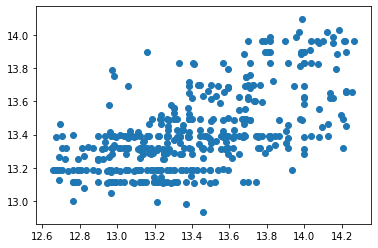

In [129]:
plt.scatter(y_test, pred)

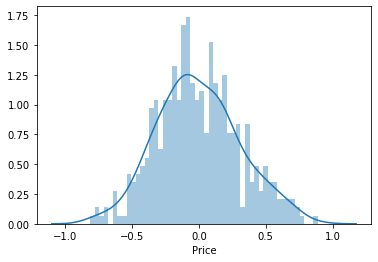

In [130]:
sns.distplot((y_test - pred), bins=50);

In [131]:


print_evaluate(y_test, lin_reg.predict(X_test))



MAE: 0.24806112975033562
MSE: 0.09521600458030872
RMSE: 0.308570906892255
R2 Square 0.382905733500042


In [132]:
results_df = pd.DataFrame(data=[["Linear Regression", *evaluate(y_test, pred) , cross_val(LinearRegression())]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_df

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Linear Regression,0.248,0.095,0.309,0.383,0.319


In [133]:
# # open a file, where you ant to store the data
# file = open('lin_reg2.pkl', 'wb')

# # dump information to that file
# pickle.dump(lin_reg, file)
with open('lin_reg5.pkl','wb') as f:
    pickle.dump(lin_reg,f)

In [134]:
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))        

seaborn==0.9.0
scikit-learn==0.21.3
pandas==1.0.4
numpy==1.16.5
matplotlib==3.1.1


In [135]:
house_df["House Type"].unique()

array(['apartment', 'condo', 'townhouse', 'house', 'others', 'duplex'],
      dtype=object)

In [136]:
house_df["Parking Type"].unique()

array(['attached garage', 'detached garage', 'no parking',
       'street parking'], dtype=object)

In [137]:
house_df["Bedroom"].unique()

array([1, 6, 2, 3, 4, 5, 0], dtype=int64)

In [138]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1410 entries, 2 to 2787
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Price         1410 non-null   float64
 1   Bedroom       1410 non-null   int64  
 2   Area          1410 non-null   float64
 3   isFurnished   1410 non-null   object 
 4   House Type    1410 non-null   object 
 5   Parking Type  1410 non-null   object 
 6   Bathroom      1410 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 88.1+ KB


In [145]:
# x=[bedroom,area,bathroom, isFurnished, house_Type_condo, house_Type_duplex, house_Type_house, house_Type_others,
#           house_Type_townhouse, parking_type_detached, parking_type_no, parking_type_street]
x=[2,1232,2, 1, 0, 0, 0, 0,
          1, 0, 0, 0]

In [146]:
prediction=lin_reg.predict([x])

In [147]:
prediction

array([13.28971919])

In [148]:
price = np.exp(prediction)
price=round(price[0],2)
price

591087.41